In [1]:
import sys
sys.path.append('/home/emastr/phd/')

import dolfin as dl
import mshr as ms
import numpy as np
import matplotlib.pyplot as plt
from hmm.stokes_fenics import StokesMacProb, StokesData, MacroSol, MacroSolver, StokesMicProb, MicroSolver, StokesHMMProblem, macro_to_micro, micros_to_macro
from hmm.hmm import IterativeHMMSolver
from util.basis_scaled import FourBasis, ScaleShiftedBasis
from util.mesh_tools import Box, order_connected_vertices, boundary_bbox_tree, find_intersection_on_segment
from util.random import smooth_random_loop_fourier_coef

## Domain
Start by defining the domain. A channel flow with random inclusions.


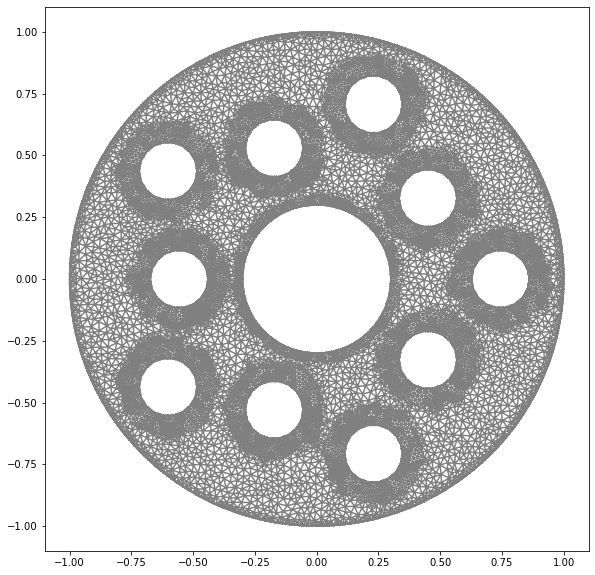

In [2]:
R = 1
r = 0.3

N_blobs = 10
thetas = np.linspace(0, 2*np.pi, N_blobs+1)[:-1]
pos_blob = (R + r) / 2
r_blob = (R - r) / 6
pos = lambda theta: np.cos(N_blobs/2 * theta) * ((R - r)*(0.3) - r_blob) + pos_blob
centers = [dl.Point(pos(theta)*np.cos(theta), pos(theta)*np.sin(theta)) for theta in thetas]

class CircleDomain(dl.SubDomain):
    def __init__(self, x, y, r, tol, bdry=True):
        self.x = x
        self.y = y
        self.r = r
        self.tol = tol
        self.bdry = bdry
        super(CircleDomain, self).__init__()
        
    def inside(self, x, on_boundary):
        if self.bdry:
            return bool(dl.near((x[0]-self.x)**2 + (x[1]-self.y)**2, self.r**2, self.tol) and on_boundary)
        else:
            return bool(dl.near((x[0]-self.x)**2 + (x[1]-self.y)**2, self.r**2, self.tol))


class UnionDomain(dl.SubDomain):
    def __init__(self, domains):
        self.domains = domains
        super(UnionDomain, self).__init__()
    
    def inside(self, x, on_boundary):
        return bool(any([domain.inside(x, on_boundary) for domain in self.domains]))

class Floor(dl.SubDomain):
    def inside(self, x, on_boundary):
        return bool(False) #bool(dl.near((x[0]-c.x())**2 + (x[1]-c.y())**2, r_blob**2))


def circle(x, y, r, N):
    #t = np.linspace(0, 2*np.pi, N+1)[:-1]
    #return ms.Polygon([dl.Point(x + r*np.cos(ti), y + r*np.sin(ti)) for ti in t])
    return ms.Circle(dl.Point(x, y), r)#), N)

### SUBDOMAINS ###
TOL = 0.03
outer = CircleDomain(0, 0, R, TOL, False)
inner = CircleDomain(0, 0, r, TOL, False)
inclusions = [CircleDomain(centers[i].x(), centers[i].y(), r_blob, TOL, False) for i in range(N_blobs)]
inclusion_union = UnionDomain(inclusions)

outer_bdry = CircleDomain(0, 0, R, TOL, True)
inner_bdry = CircleDomain(0, 0, r, TOL, True)
inclusion_boundaries = [CircleDomain(centers[i].x(), centers[i].y(), r_blob, TOL, True) for i in range(N_blobs)]



#### MESH ####
domain = circle(0,0,R,400) - circle(0, 0, r, 200)
for i in range(N_blobs):
    #poly = ms.Circle(centers[i], r_blob)
    poly = circle(centers[i].x(), centers[i].y(), r_blob, 200)
    domain = domain - poly
mesh = ms.generate_mesh(domain, resolution=50)


mesh_func = dl.MeshFunction("bool", mesh, mesh.topology().dim()-1, False)
outer.mark(mesh_func, True)
inner.mark(mesh_func, True)
inclusion_union.mark(mesh_func, True)
for inclusion in inclusions:
    inclusion.mark(mesh_func, True)
mesh = dl.refine(mesh, mesh_func)

plt.figure(figsize=(10,10))
dl.plot(mesh)

In [3]:
# Define the function spaces
P2 = dl.VectorElement(family='P', cell=dl.triangle, degree=2)
P1 = dl.FiniteElement(family='P', cell=dl.triangle, degree=1)
P2P1 = P2 * P1
W = dl.FunctionSpace(mesh, P2P1)
U, P = W.split() 
Ux, Uy = U.split()

# Boundary Conditions
bcu_inner = dl.DirichletBC(U, dl.Expression((f'x[1]/{r}', f'-x[0]/{r}'), degree=2), inner_bdry)
bcu_outer = dl.DirichletBC(U, dl.Expression((f'x[1]/{R}', f'-x[0]/{R}'), degree=2), outer_bdry)
bcu_inclusions = [dl.DirichletBC(U, dl.Constant((0., 0.)), inclusion) for inclusion in inclusion_boundaries]
#bcu_inclusion = dl.DirichletBC(U, dl.Constant((0,0)), inclusion_union)

solve
Notation dx[meshfunction] is deprecated. Please use dx(subdomain_data=meshfunction) instead.
Solving linear variational problem.


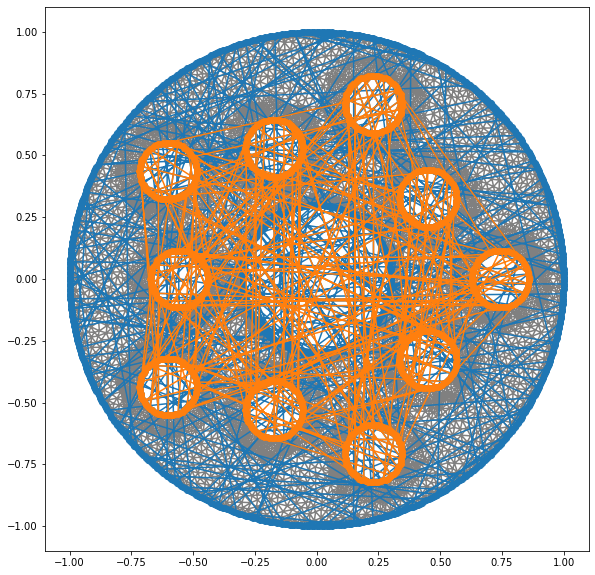

In [4]:
print("solve")


#bcu = [bcu_outer, bcu_inner] + bcu_inclusions
#bcu = [bcu_outer, bcu_inner]

bcu = [bcu_outer] + bcu_inclusions
data = StokesData.from_mesh(mesh, inner, None, W, bcu)

bcu = [bcu_outer, bcu_inner]
data = StokesData.from_mesh(mesh, inclusion_union, None, W, bcu)
#data = StokesData(mesh, None, None, None, inclusion_union, None, W, bcu)    




plt.figure(figsize=(10,10))
bmesh = dl.BoundaryMesh(data.macro_mesh, 'exterior')
slipMesh = dl.SubMesh(bmesh, inclusion_union)
dl.plot(bmesh)
dl.plot(slipMesh)
dl.plot(data.macro_mesh)

def interp(x, a):
    amean = np.mean(a)
    return lambda x, y: amean #basis(np.array([x]))[0]

mac = StokesMacProb(data, interp=interp, alpha0=lambda x,y: 1e-1, lam=1e4)
mac_solver = MacroSolver()

sol = mac_solver.solve(mac, verbose=True)

Object cannot be plotted directly, projecting to piecewise linears.
Help on BoundingBoxTree in module dolfin.cpp.geometry object:

class BoundingBoxTree(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      BoundingBoxTree
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: dolfin.cpp.geometry.BoundingBoxTree) -> None
 |  
 |  build(...)
 |      build(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. build(self: dolfin.cpp.geometry.BoundingBoxTree, arg0: dolfin.cpp.mesh.Mesh) -> None
 |      
 |      2. build(self: dolfin.cpp.geometry.BoundingBoxTree, arg0: dolfin.cpp.mesh.Mesh, arg1: int) -> None
 |  
 |  compute_closest_entity(...)
 |      compute_closest_entity(self: dolfin.cpp.geometry.BoundingBoxTree, arg0: dolfin::Point) -> Tuple[int, float]
 |  
 |  compute_collisions(...)
 |      compute_collisions(*args, **kwargs)
 |      Overloaded function.
 |      
 |

AttributeError: 'dolfin.cpp.geometry.BoundingBoxTree' object has no attribute 'compute_colliding_cells'

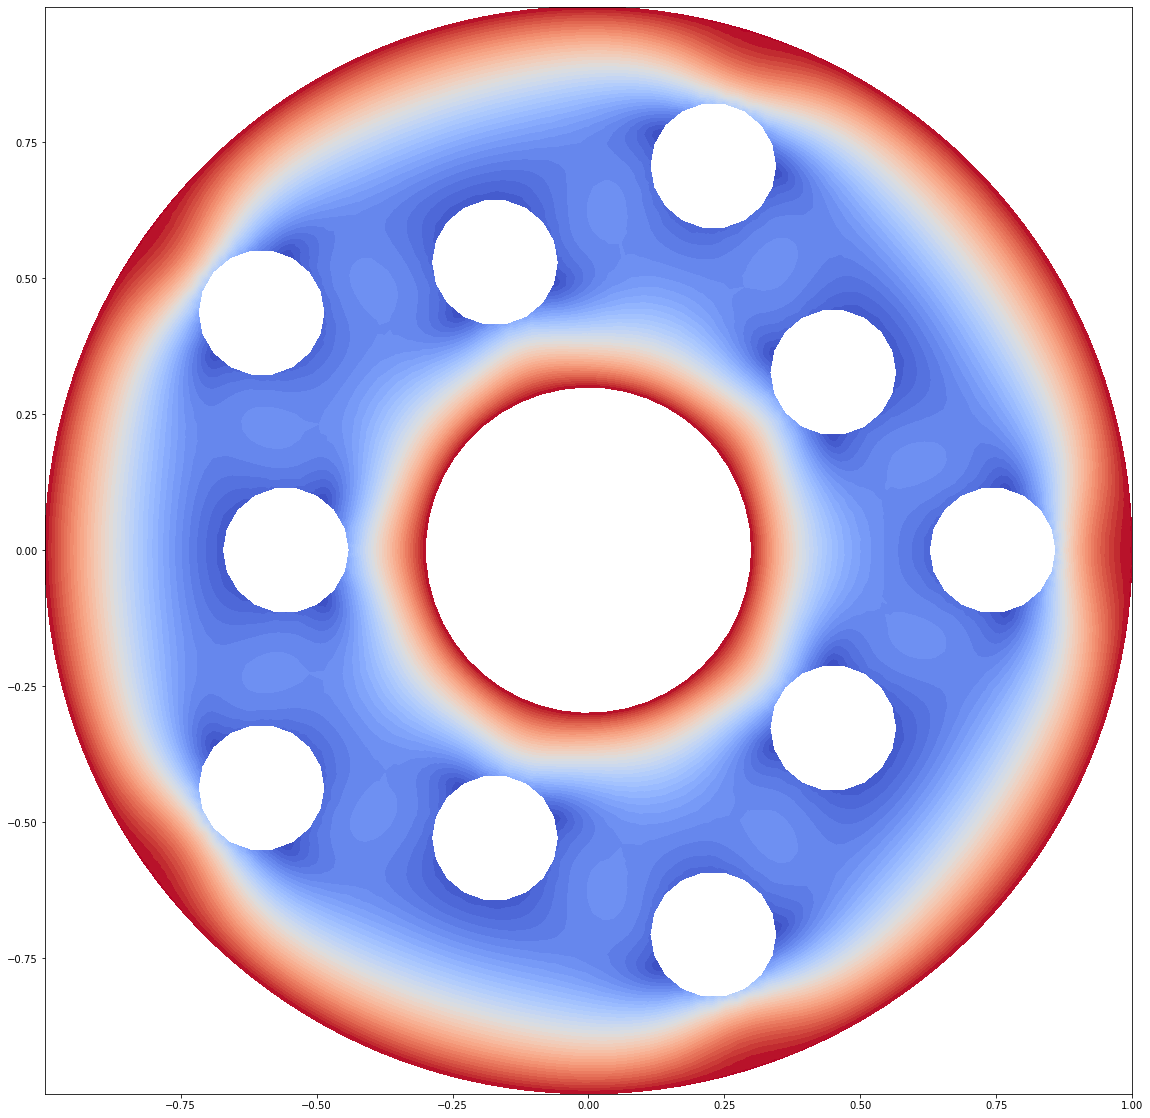

In [5]:
#sol.u.vector()[:] = np.where(np.isnan(sol.u.vector()[:]), 0, sol.u.vector()[:])
#sol.v.vector()[:] = np.where(np.isnan(sol.v.vector()[:]), 0, sol.v.vector()[:])
abs_u = (sol.u * sol.u + sol.v * sol.v) ** 0.5
w = sol.grad_u[1] - sol.grad_v[0]
#print(sol.u.vector()[:])

plt.figure(figsize=(20,20))
dl.plot(abs_u, cmap='coolwarm', vmin=0., vmax=1.)
sol.plot_stream(plt.gca(), dom=mesh, bbox=[[-1.,1.], [-1., 1.]], npts=150, color='white')

plt.figure(figsize=(20,20))
dl.plot(w, cmap='coolwarm', vmin=-10., vmax=10.)

plt.figure(figsize=(20,20))
dl.plot(sol.p, cmap='coolwarm')#, vmin=-20., vmax=20.)




In [12]:
mac_guess = mac_solver.solve(mac)
mac_sol, mic_sols = hmm_solver.solve(hmm_prob, mac_guess, maxiter=20)

Solving linear variational problem.


NameError: name 'hmm_solver' is not defined

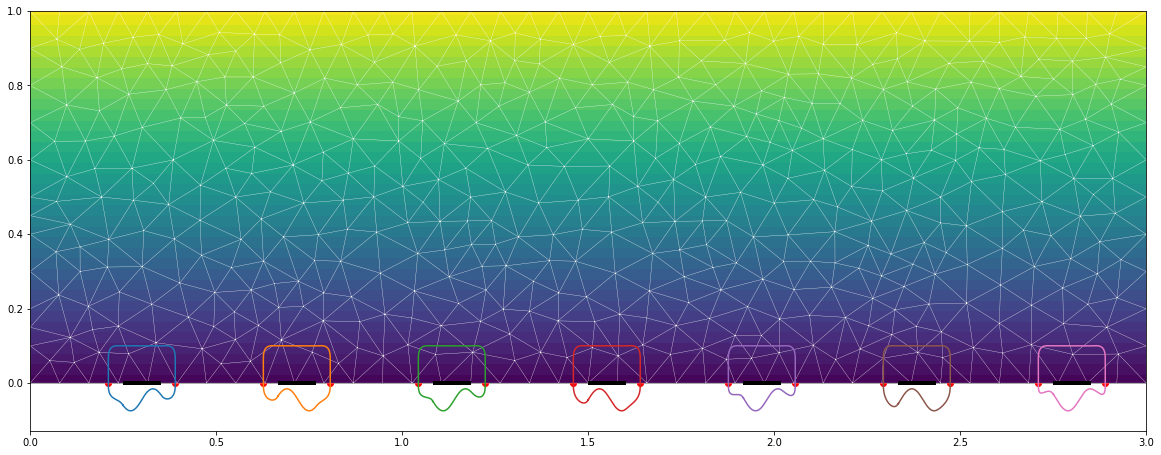

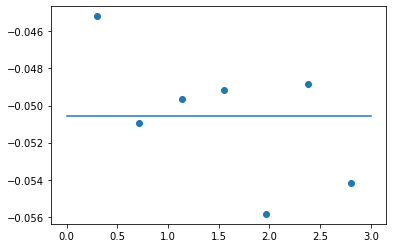

In [ ]:
plt.figure(figsize=(20,10))
hmm_prob.plot(plt.gca())
dl.plot(mac_sol.u)
data.plot(plt.gca(), linewidth=0.3, color="white")

plt.figure()
x = np.linspace(*bbox[0])
y = x * 0
a = np.array([mac.interp_a(xi,yi) for xi,yi in zip(x, y)])
plt.plot(x, a)
plt.scatter([s.x[0] for s in mic_sols], [s.alpha for s in mic_sols])

Solving linear variational problem.


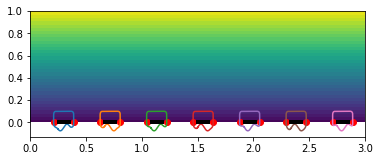

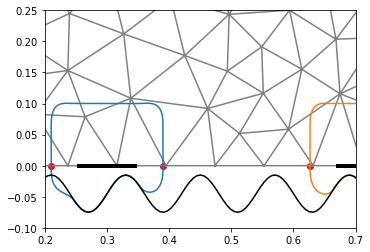

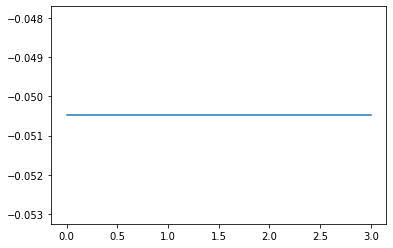

In [ ]:
mac_sol = mac_solver.solve(mac)
for mic in mics:
    mic.update(mac_sol)
mic_sols = [mic_solver.solve(mic) for mic, mic_solver in zip(mics, mic_solvers)]
mac.update(mic_sols)


dl.plot(mac_sol.u)
for mic in mics:
    mic.plot(plt.gca(), npts=500)


plt.figure()
for mic in mics:
    mic.plot(plt.gca(), npts=500)
dl.plot(data.macro_mesh)
plt.plot(rough_boundary[:, 0], rough_boundary[:, 1], 'k')
plt.xlim([0.2, 0.7])
plt.ylim([-0.1, 0.25])


plt.figure()
x = np.linspace(*bbox[0])
y = x * 0
a = np.array([mac.interp_a(xi,yi) for xi,yi in zip(x, y)])
plt.plot(x, a)

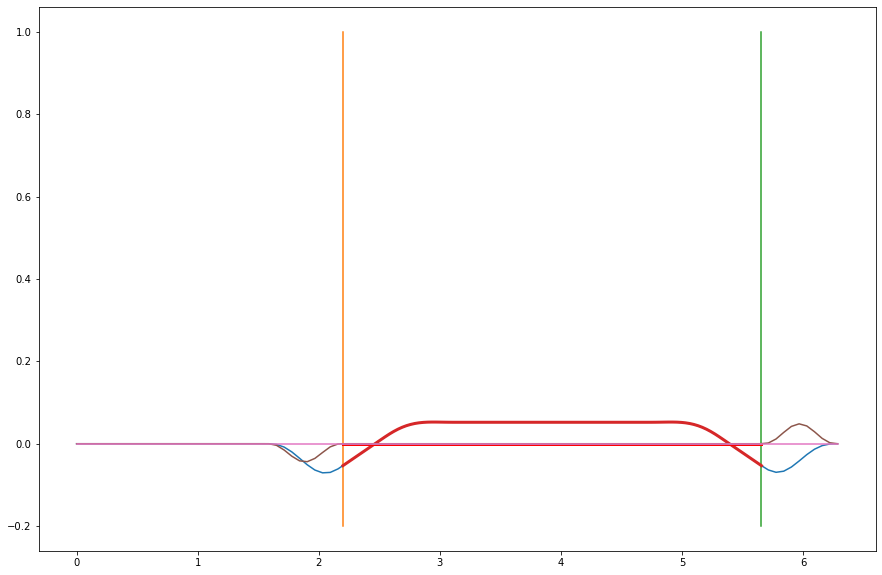

In [ ]:
plt.figure(figsize=(15, 10))
mic.update(mac_sol)
t = np.linspace(0, 2*np.pi, 100)
g = mic.condition(t)
t0 = mic.feasible_domain

ts = np.linspace(t0[0], t0[1], 100)
z = mic.geom.eval_param(t=ts)
pts = [dl.Point(zv.real, zv.imag) for zv in z]
u = np.array([mac_sol.u(p) for p in pts])
v = np.array([mac_sol.v(p) for p in pts])
gu = np.array([mac_sol.grad_u(p)[1] for p in pts])
gv = np.array([mac_sol.grad_v(p)[1] for p in pts])

plt.plot(t, g.real)
plt.plot([t0, t0], [-0.2, 1])
plt.plot(ts, u, linewidth=3)
plt.plot(ts, v, color='r', linewidth=3)
plt.plot(ts, gv)
plt.plot(t, g.imag)
plt.plot(t, 0*t)